# Generative Adversarial Networks (GANs)

# Deep Learning Project 2 - GAN
Samyam Lamichhane  <br>
May 01, 2023

---------------

# Introduction to Generative Modeling

Deep neural networks are used mainly for supervised learning: classification or regression. Generative Adversarial Networks or GANs, however, use neural networks for a very different purpose: Generative modeling

> Generative modeling is an unsupervised learning task in machine learning that involves automatically discovering and learning the regularities or patterns in input data in such a way that the model can be used to generate or output new examples that plausibly could have been drawn from the original dataset. - [Source](https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/)

While there are many approaches used for generative modeling, a Generative Adversarial Network takes the following approach: 

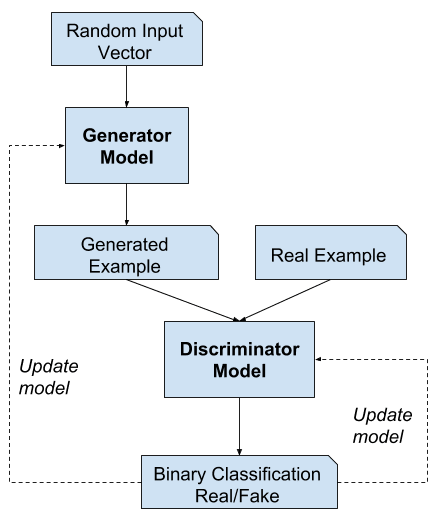

There are two neural networks: a *Generator* and a *Discriminator*. The generator generates a "fake" sample given a random vector/matrix, and the discriminator attempts to detect whether a given sample is "real" (picked from the training data) or "fake" (generated by the generator). Training happens in tandem: train the discriminator for a few epochs, then train the generator for a few epochs, and repeat. This way both the generator and the discriminator get better at doing their jobs. 

GANs however, can be notoriously difficult to train, and are extremely sensitive to hyperparameters, activation functions and regularization. In this tutorial, we'll train a GAN to generate images of anime characters' faces.

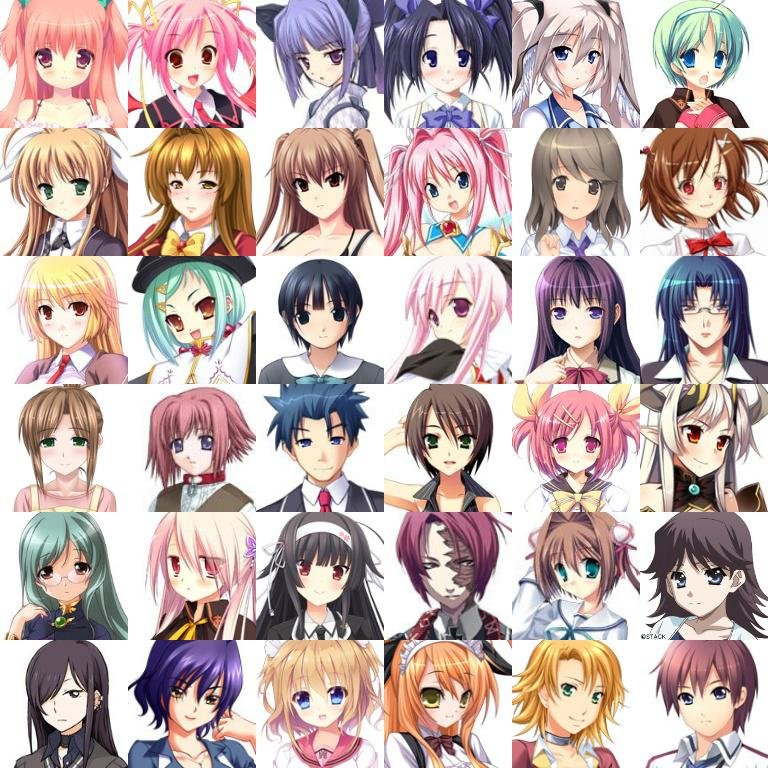

Use the [Anime Face Dataset](https://github.com/Mckinsey666/Anime-Face-Dataset), which consists of over 63,000 cropped anime faces. Note that generative modeling is an unsupervised learning task, so the images do not have any labels. Most of the code in this tutorial is based [on this notebook](https://www.kaggle.com/splcher/starter-anime-face-dataset). 

In [1]:
# Uncomment and run the appropriate command for your operating system, if required
# No installation is reqiured on Google Colab / Kaggle notebooks

# Linux / Binder / Windows (No GPU)
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Linux / Windows (GPU)
# pip install numpy matplotlib torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
 
# MacOS (NO GPU)
# !pip install numpy matplotlib torch torchvision torchaudio

## Exploring the Data

The dataset has a single folder called `images` which contains all 63,000+ images in JPG format.

In [2]:
import os
DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [3]:
print(os.listdir(DATA_DIR+'/images')[:10])

['6626_2003.jpg', '56739_2017.jpg', '37681_2012.jpg', '55083_2016.jpg', '339_2000.jpg', '33307_2011.jpg', '12051_2005.jpg', '35259_2011.jpg', '21183_2008.jpg', '37899_2012.jpg']


Let's load this dataset using the `ImageFolder` class from `torchvision`. Resize and crop the images to 64x64 px, and normalize the pixel values with a mean & standard deviation of 0.5 for each channel. This will ensure that pixel values are in the range `(-1, 1)`, which is more  convenient for training the discriminator. We will also create a data loader to load the data in batches.

In [4]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [5]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [6]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

Let's create helper functions to denormalize the image tensors and display some sample images from a training batch.

In [7]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
#image = ((image * std) + mean) --> transform image back in [0 1] range
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [9]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

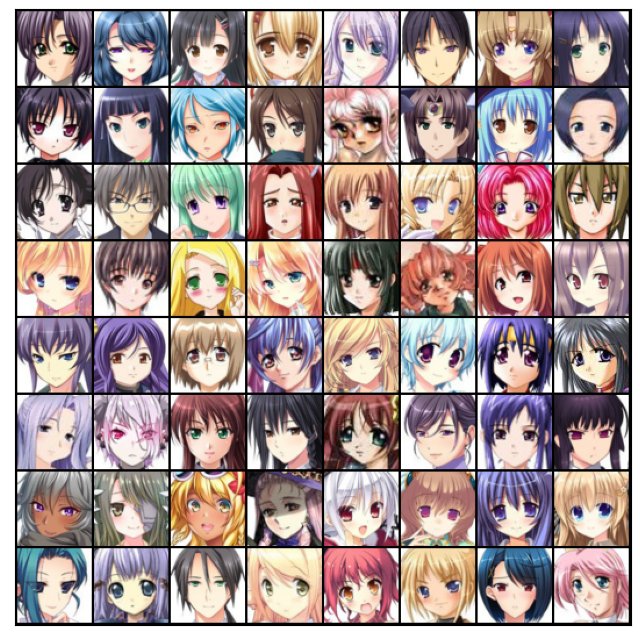

In [10]:
show_batch(train_dl)

## Using a GPU

To seamlessly use a GPU, if one is available, use a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move model & data to the GPU, if one is available.

In [11]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`).

In [12]:
device = get_default_device()
device

device(type='cuda')

We can now move our training data loader using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available).

In [13]:
train_dl = DeviceDataLoader(train_dl, device)

## Discriminator Network

The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. Use a convolutional neural networks (CNN) which outputs a single number output for every image. Use a stride of 2 to progressively reduce the size of the output feature map.

![](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides_odd.gif)

In [14]:
import torch.nn as nn

Convolution Formula:   

$$ o = \frac{i - k + 2 * p}{s} + 1 $$

where, 
$$ o = \text{output size} $$
$$ i = \text{input size} $$
$$ k = \text{kernel size} $$
$$ p = \text{padding} $$
$$ s = \text{stride} $$

In [15]:


'''


Parameters for Conv2d (Using the formula above, the following values are computed)
    
    For:
    3 x 64 x 64   -> 64 x 32 x 32   & 
    64 x 32 x 32  -> 128 x 16 x 16  & 
    128 x 16 x 16 -> 256 x 8 x 8    & 
    256 x 8 x 8   -> 512 x 4 x 4
        
        Kernel = 4, Stride = 2 and Padding = 1
    
    
    For:
    512 x 4 x 4   -> 1 x 1 x
        
        Kernel = 4, Stride = 1 and Padding = 0

'''




# Discriminator Function that derives from "torch.nn"
# Performs binary classification on the image received - generated or original
# For each step, perform (1) Convolution, (2) Batch Normalization and (3) Leaky ReLU
# For the final step, perform (1) Convolution

discriminator = nn.Sequential(
    
    # in:  3 x 64 x 64
    # out: 64 x 32 x 32
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    

    # in:  64 x 32 x 32
    # out: 128 x 16 x 16
    # add appropriate NN layers (conv2d, batch norm and leaky relu)
    nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace = True),


    # in:  128 x 16 x 16
    # out: 256 x 8 x 8
    nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace = True),
    

    # in:  256 x 8 x 8
    # out: 512 x 4 x 4
    nn.Conv2d(256, 512, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace = True),

    
    # in:  512 x 4 x 4
    # out: 1 x 1 x 1
    # Add only conv2d layer here to output 1x1x1 value
    nn.Conv2d(512, 1, kernel_size = 4, stride = 1, padding = 0, bias = False),

    
    # Flatten the tensor 
    # in: [[[value]]] -> value
    nn.Flatten(),
    
    # Activation Function
    nn.Sigmoid())


Note that we're using the Leaky ReLU activation for the discriminator.

<img src="https://cdn-images-1.medium.com/max/1600/1*ypsvQH7kvtI2BhzR2eT_Sw.png" width="420">


>  Different from the regular ReLU function, Leaky ReLU allows the pass of a small gradient signal for negative values. As a result, it makes the gradients from the discriminator flows stronger into the generator. Instead of passing a gradient (slope) of 0 in the back-prop pass, it passes a small negative gradient.  - [Source](https://sthalles.github.io/advanced_gans/)

Just like any other binary classification model, the output of the discriminator is a single number between 0 and 1, which can be interpreted as the probability of the input image being real i.e. picked from the original dataset.

Let's move the discriminator model to the chosen device.

In [16]:
discriminator = to_device(discriminator, device)

## Generator Network

The input to the generator is typically a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image. The generator will convert a latent tensor of shape `(128, 1, 1)` into an image tensor of shape `3 x 28 x 28`. To achive this, we'll use the `ConvTranspose2d` layer from PyTorch, which is performs to as a *transposed convolution* (also referred to as a *deconvolution*). [Learn more](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md#transposed-convolution-animations)

![](https://i.imgur.com/DRvK546.gif)

In [17]:
latent_size = 128

In [18]:

'''


Parameters for ConvTranspose2d (Using the same formula above)
    
    For:
    latent_size x 1 x 1 ->  512 x 4 x 4
    
        Kernel = 4, Stride = 1, Padding = 0
        
    
    For: 
    512 x 4 x 4         ->  256 x 8 x 8    & 
    256 x 8 x 8         ->  128 x 16 x 16  & 
    128 x 16 x 16       ->  64 x 32 x 32   & 
    64 x 32 x 32        ->  3 x 64 x 64
        
        Kernel = 4, Stride = 2 and Padding = 1


'''



# Generator Function that derives from "torch.nn"
# Generates images based on input vector
# For each step, perform (1) Transposed Convolution, (2) Batch Normalization and (3) ReLU
# For the final step, perform (1) Transposed Convolution

generator = nn.Sequential(
    
    # in: latent_size x 1 x 1
    # out: 512 x 4 x 4
    nn.ConvTranspose2d(latent_size, 512, kernel_size = 4, stride = 1, padding = 0, bias = False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    # in:  512 x 4 x 4
    # out: 256 x 8 x 8
    nn.ConvTranspose2d(512, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    # in:  256 x 8 x 8
    # out: 128 x 16 x 16
    nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    # in:  128 x 16 x 16
    # out: 64 x 32 x 32
    nn.ConvTranspose2d(128, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    
    # in:  64 x 32 x 32
    # out: 3 x 64 x 64
    nn.ConvTranspose2d(64, 3, kernel_size = 4, stride = 2, padding = 1, bias = False),
    
    
    
    # Perform tanh() activation
    # Changes range to [-1, 1]
    nn.Tanh()

)

We use the TanH activation function for the output layer of the generator.

<img src="https://nic.schraudolph.org/teach/NNcourse/figs/tanh.gif" width="420" >

> "The ReLU activation (Nair & Hinton, 2010) is used in the generator with the exception of the output layer which uses the Tanh function. We observed that using a bounded activation allowed the model to learn more quickly to saturate and cover the color space of the training distribution. Within the discriminator we found the leaky rectified activation (Maas et al., 2013) (Xu et al., 2015) to work well, especially for higher resolution modeling." - [Source](https://stackoverflow.com/questions/41489907/generative-adversarial-networks-tanh)


Note that since the outputs of the TanH activation lie in the range `[-1,1]`, we have applied the similar transformation to the images in the training dataset. Let's generate some outputs using the generator and view them as images by transforming and denormalizing the output.

torch.Size([128, 3, 64, 64])


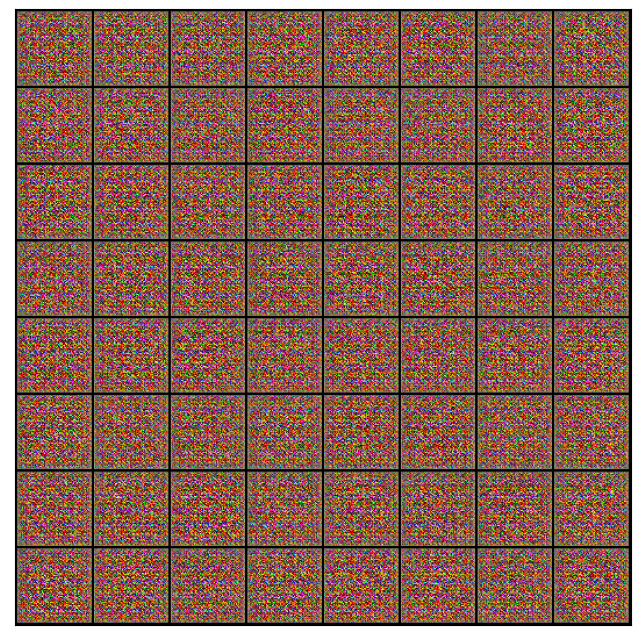

In [19]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

As one might expect, the output from the generator is basically random noise, since we haven't trained it yet. 

Let's move the generator to the chosen device.

In [20]:
generator = to_device(generator, device)

## Discriminator Training

Since the discriminator is a binary classification model, we can use the binary cross entropy loss function to quantify how well it is able to differentiate between real and generated images.

<img src="https://image.slidesharecdn.com/chrishokamp-dublinnlp3-160805110319/95/task-based-learning-for-nlp-going-beyond-cross-entropy-chris-hokamp-10-638.jpg?cb=1470395213" width="420" >

In [21]:
'''

Arguments:
    Real Images fed to discriminator & Optimizer for discriminator

Returns: 
    Loss for each cases, Score for Real images, Score for Fake images

'''


# Function to train the discriminator
def train_discriminator(real_images, opt_d):
    
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device = device)    # Compare fake image to 1 so torch.ones
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device = device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_preds = discriminator(fake_images)
    fake_targets = torch.zeros(fake_images.size(0), 1, device = device)   # Compare fake image to 0 so torch.zeros
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()
    

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    
    
    return loss.item(), real_score, fake_score

Here are the steps involved in training the discriminator.

- We expect the discriminator to output 1 if the image was picked from the real Anime dataset, and 0 if it was generated using the generator network. 

- We first pass a batch of real images, and compute the loss, setting the target labels to 1. 

- Then we pass a batch of fake images (generated using the generator) pass them into the discriminator, and compute the loss, setting the target labels to 0. 

- Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.

It's important to note that we don't change the weights of the generator model while training the discriminator (`opt_d` only affects the `discriminator.parameters()`)

## Generator Training

Since the outputs of the generator are images, it's not obvious how we can train the generator. This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function. Here's how it works:

- We generate a batch of images using the generator, pass the into the discriminator.

- We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator. 

- We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.

Here's what this looks like in code.

In [22]:

'''
Argument: 
    Optimizer for generator
    
Returns:
    Loss value for each image

'''


# Function to train generator 
def train_generator(opt_g):
    
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device = device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device = device)           # Compare values with a tensor of '1'
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

Let's create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model. We'll also create a helper function to export the generated images.

In [23]:
from torchvision.utils import save_image

In [24]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [25]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model. Let's save one set of images before we start training our model.

In [26]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


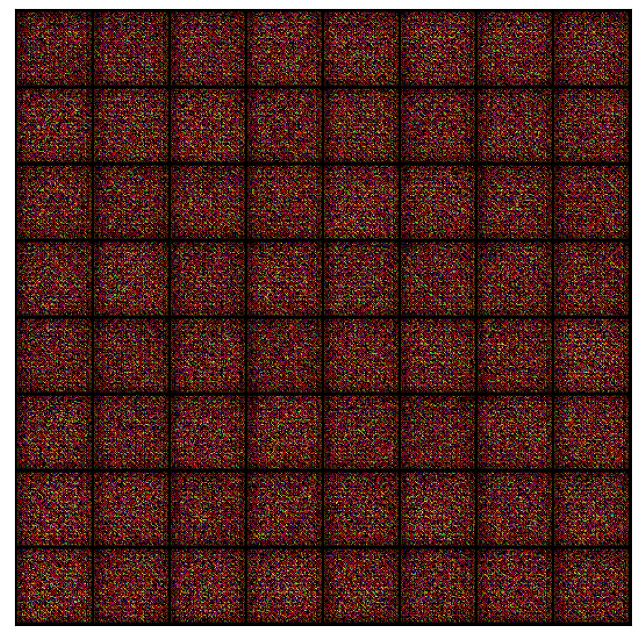

In [27]:
save_samples(0, fixed_latent)

## Full Training Loop

Let's define a `fit` function to train the discriminator and generator in tandem for each batch of training data. We'll use the Adam optimizer with some custom parameters (betas) that are known to work well for GANs. We will also save some sample generated images at regular intervals for inspection.

<img src="https://i.imgur.com/6NMdO9u.png" style="max-width:420px; margin-bottom:32px"/>



In [28]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [29]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    
    # Loop through epochs number of times
    # In each iteration, loop through train_data and train discriminator and generator respectively
    # At the end of each iteration, append loss and score values to respective lists
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            
            # Train discriminator
            # Function Call
            # Pass appropriate arguments and store returned values
            dis_loss, score_real, score_fake = train_discriminator(real_images, opt_d)
            
            # Train generator
            # Function Call
            # Pass appropriate arguments and store returned values
            gen_loss = train_generator(opt_g)
            
        
        # Record losses & scores
        # From discriminator training
        losses_d.append(dis_loss)
        real_scores.append(score_real)
        fake_scores.append(score_fake)
        
        # From generator training
        losses_g.append(gen_loss)
        
        
        # Log losses & scores (last batch)
        '''
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
        '''
        
        print("Epoch [{}/{}], gen_loss: {:.4f}, dis_loss: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, gen_loss, dis_loss, score_real, score_fake))
    
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores


We are now ready to train the model. Try different learning rates to see if you can maintain the fine balance between the training the generator and the discriminator.

In [30]:
lr = 0.0002
epochs = 25

In [31]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/25], gen_loss: 4.1683, dis_loss: 0.3389, real_score: 0.7730, fake_score: 0.0254
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/25], gen_loss: 4.0797, dis_loss: 0.4262, real_score: 0.7821, fake_score: 0.1279
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/25], gen_loss: 6.3503, dis_loss: 0.4855, real_score: 0.8739, fake_score: 0.2541
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/25], gen_loss: 6.6247, dis_loss: 0.3758, real_score: 0.9140, fake_score: 0.2177
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/25], gen_loss: 4.0104, dis_loss: 0.2312, real_score: 0.8593, fake_score: 0.0527
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/25], gen_loss: 5.0429, dis_loss: 0.4411, real_score: 0.7279, fake_score: 0.0028
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/25], gen_loss: 6.1207, dis_loss: 0.6008, real_score: 0.6263, fake_score: 0.0008
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/25], gen_loss: 11.0732, dis_loss: 0.0067, real_score: 0.9945, fake_score: 0.0010
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/25], gen_loss: 4.3413, dis_loss: 0.1495, real_score: 0.8972, fake_score: 0.0293
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/25], gen_loss: 3.5190, dis_loss: 0.2852, real_score: 0.8244, fake_score: 0.0372
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/25], gen_loss: 3.7747, dis_loss: 0.2083, real_score: 0.8754, fake_score: 0.0447
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/25], gen_loss: 5.1540, dis_loss: 0.2594, real_score: 0.9340, fake_score: 0.1525
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/25], gen_loss: 4.5152, dis_loss: 0.1247, real_score: 0.9327, fake_score: 0.0482
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/25], gen_loss: 4.0982, dis_loss: 0.1296, real_score: 0.9515, fake_score: 0.0705
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/25], gen_loss: 2.9960, dis_loss: 0.1901, real_score: 0.9249, fake_score: 0.0891
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/25], gen_loss: 3.5892, dis_loss: 0.2642, real_score: 0.8141, fake_score: 0.0184
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/25], gen_loss: 5.1116, dis_loss: 0.1322, real_score: 0.9604, fake_score: 0.0823
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/25], gen_loss: 3.7388, dis_loss: 0.1511, real_score: 0.9470, fake_score: 0.0848
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/25], gen_loss: 5.7107, dis_loss: 0.1129, real_score: 0.9802, fake_score: 0.0822
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/25], gen_loss: 4.7501, dis_loss: 0.1335, real_score: 0.9430, fake_score: 0.0482
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/25], gen_loss: 3.7161, dis_loss: 0.1610, real_score: 0.8966, fake_score: 0.0379
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/25], gen_loss: 12.5158, dis_loss: 2.8230, real_score: 0.9999, fake_score: 0.8899
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/25], gen_loss: 2.6103, dis_loss: 0.1897, real_score: 0.8820, fake_score: 0.0465
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/25], gen_loss: 4.2810, dis_loss: 0.1138, real_score: 0.9560, fake_score: 0.0613
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/25], gen_loss: 4.9314, dis_loss: 0.1131, real_score: 0.9448, fake_score: 0.0487
Saving generated-images-0025.png


In [32]:
losses_g, losses_d, real_scores, fake_scores = history

Now that we have trained the models, we can save checkpoints.

In [33]:
# Save the model checkpoints 
torch.save(generator.state_dict(), './model/G.pth')
torch.save(discriminator.state_dict(), './model/D.pth')

Here's how the generated images look, after the 1st, 5th and 10th epochs of training.

In [34]:
from IPython.display import Image

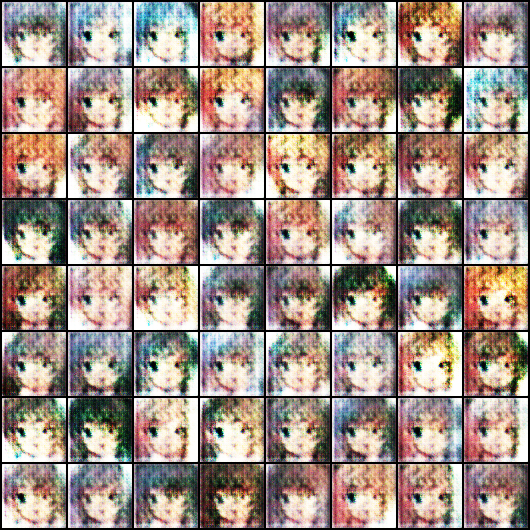

In [35]:
Image('./generated/generated-images-0001.png')

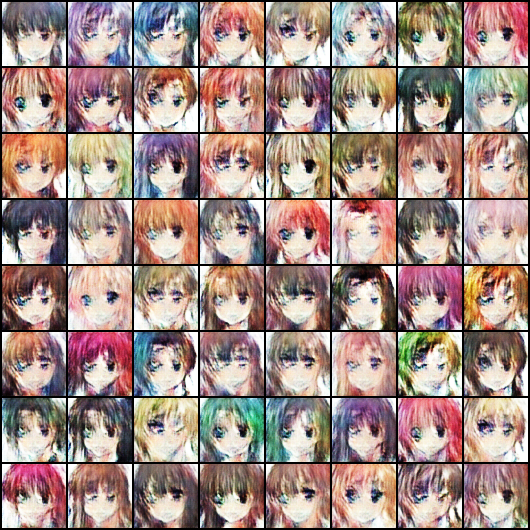

In [36]:
Image('./generated/generated-images-0005.png')

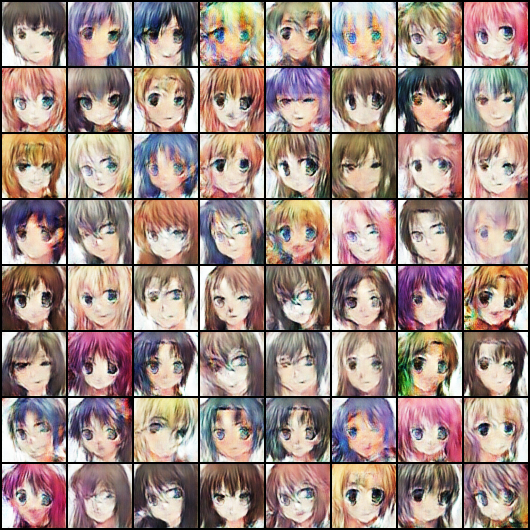

In [37]:
Image('./generated/generated-images-0010.png')

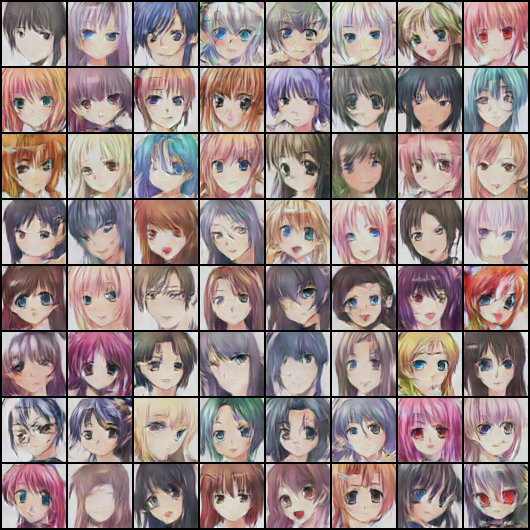

In [38]:
Image('./generated/generated-images-0020.png')

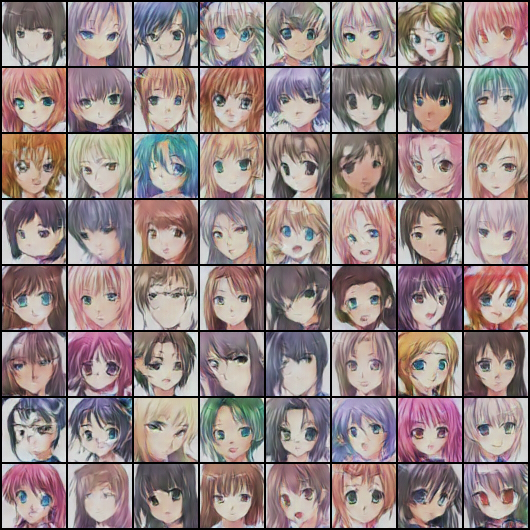

In [39]:
Image('./generated/generated-images-0025.png')

Visualize how the loss changes over time. Visualizing 
losses is quite useful for debugging the training process. For GANs, we expect the generator's loss to reduce over time, without the discriminator's loss getting too high.



In [40]:
# X-Axis values
import numpy as np
x_axis = np.arange(0, epochs)

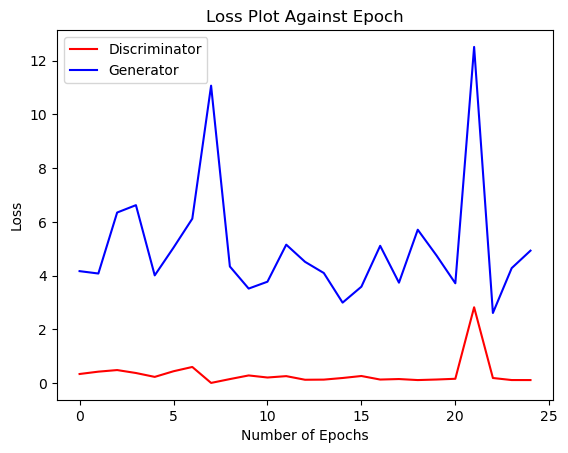

In [41]:

# Plot Loss of Generator and Discriminator

plt.plot(x_axis, losses_d, color = "r", label = 'Discriminator')
plt.plot(x_axis, losses_g, color = "b", label = 'Generator')

plt.title("Loss Plot Against Epoch")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

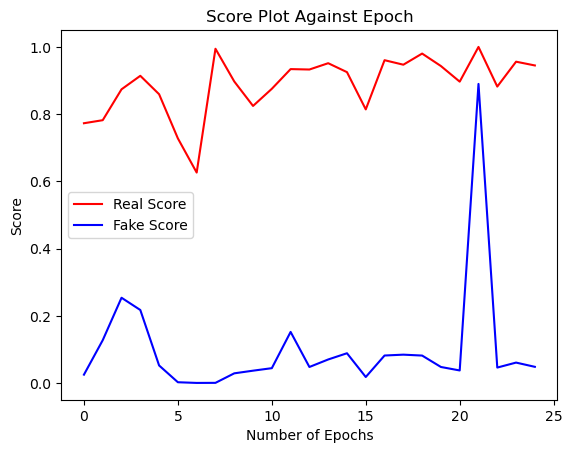

In [42]:

#Plot Real and Fake scores

plt.plot(x_axis, real_scores, color = "r", label = 'Real Score')
plt.plot(x_axis, fake_scores, color = "b", label = 'Fake Score')

plt.title("Score Plot Against Epoch")
plt.xlabel("Number of Epochs")
plt.ylabel("Score")
plt.legend()
plt.show()